# Modelling

This notebook picks up the previously cleaned and merged data, creates some new and pre-processes features, trains a binary classification model on the trainind set. Final section will evaluate the model.

<a href='#1'>1. Feature Selection<a>  
<a href='#2'>2. Feature Engineering<a>  
<a href='#3'>3. Pre-processing<a>  
<a href='#4'>4. Model Training<a>    
<a href='#5'>5. Model Evaluation<a>    


In [61]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Modelling
from sklearn.model_selection import train_test_split

# impute
from sklearn.impute import SimpleImputer

# pre-processing
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_curve

## 1. Feature Selection <a id='1'><a>  

In [2]:
df_hi = pd.read_parquet('../data/1_interim/1_merged_data.parquet')
df_hi.head(2)

,participant_id,name_title,first_name,last_name,age,postcode,marital_status,education,job_title,occupation_level,...,post_area_code,postcode_area,postcode_area_name,sal_lower,sal_upper,sal_freq,sal_currency,sal_togbp_rate,sal_toyearly_factor,sal_mid_gbp
0,8.997000e+12,Mr.,Dale,Coles,39,EH4 9FL,Never-married,Bachelors,Furniture conservator/restorer,1,...,EH,EH,Edinburgh,18109.0,18109.0,yearly,GBP,1.0,1.0,18109.0
1,2.764970e+12,None,Joel,Allen,50,LS5H 0JG,Married-civ-spouse,Bachelors,"Administrator, sports",4,...,LS,LS,Leeds,16945.0,16945.0,yearly,GBP,1.0,1.0,16945.0


<div class="alert alert-block alert-warning">
<b>Assumption:</b> 
The intended use of the predicitons is to pre-select mortgage customers who are likely to take out a home insurance. Considering the intended business use I assume that information from campaign table won't be available for the next campaign.   
Bacuase information from the mortgage has practical significance, <b>I only consider features from the mortgage table.<b>
</div>

The columns available or can be derived from mortgage dataset are:
- `full_name`,
- `dob`, 
- `town`,
- `paye`,
- `salary_band`,
- `years_with_employer`,
- `months_with_employer`,
- `hours_per_week`,
- `capital_gain`,
- `capital_loss`,
- `new_mortgage`,
- `sex`,
- `religion`,
- `relationship`,
- `race`,
- `native_country`,
- `workclass`,
- `demographic_characteristic`
- `sal_mid_gbp`

The target columns to predict:
- `'created_account'`

In [3]:
# mortgage_cols = []
df_hi.columns

# df_hi['marital_status'].unique()
# df_hi['relationship'].unique()
# df_hi['education'].unique()
# df_hi['job_title'].unique()
# df_hi['workclass'].unique()

Index(['participant_id', 'name_title', 'first_name', 'last_name', 'age',
       'postcode', 'marital_status', 'education', 'job_title',
       'occupation_level', 'education_num', 'familiarity_FB', 'view_FB',
       'interested_insurance', 'company_email', 'created_account', 'full_name',
       'dob', 'town', 'paye', 'salary_band', 'years_with_employer',
       'months_with_employer', 'hours_per_week', 'capital_gain',
       'capital_loss', 'new_mortgage', 'sex', 'religion', 'relationship',
       'race', 'native_country', 'workclass', 'demographic_characteristic',
       'duplicated', 'dob_yr', 'campaign_yr', 'post_area_code',
       'postcode_area', 'postcode_area_name', 'sal_lower', 'sal_upper',
       'sal_freq', 'sal_currency', 'sal_togbp_rate', 'sal_toyearly_factor',
       'sal_mid_gbp'],
      dtype='object')

## Features to include and pre-process

`'created_account'` - target variable - binary classification

`'age'` - numeric, continous (discrete)  
`'sex'` - categorical with 2 values - as boolean 0/1  
`'religion'` - categorical, non-ordinal one-hot encoding   
`'relationship'` - categorical, non-ordinal one-hot encoding  

`'education'` - categorical, ordinal encoded with integers  
`'education_num'`  
`'occupation_level'`  

`'sal_mid_gbp'` - numeric, continous

`'new_mortgage'` - categorical with 2 values - as boolean 0/1  

`years_with_employer` + `months_with_employer` - numerical continous feature as decimal years  
`hours_per_week`

## 2. Feature Engineering  <a id='2'><a>  
- Create a column representing the time spent with employer as a continous value
- Turn target column to 1 (`Yes`) and 0 (`No`)

In [4]:
# Combine time with employer columns
df_hi['time_with_employer'] = df_hi['years_with_employer'] + df_hi['months_with_employer']/12
df_hi[['time_with_employer', 'years_with_employer', 'months_with_employer']].head()

,time_with_employer,years_with_employer,months_with_employer
0,20.500000,20.0,6.0
1,28.083333,28.0,1.0
2,14.416667,14.0,5.0
3,32.500000,32.0,6.0
4,3.500000,3.0,6.0


In [7]:
cat_cols = ['relationship', 'sex', 'religion']
num_cols = ['age', 'education_num', 'occupation_level','time_with_employer', 'hours_per_week']
target_col = 'created_account'

feature_cols = cat_cols + num_cols + [target_col]

df_hi[feature_cols].isna().sum()

relationship          407
sex                   407
religion              407
age                     0
education_num           0
occupation_level        0
time_with_employer    407
hours_per_week        407
created_account         0
dtype: int64

In [8]:
# Convert target
df_hi[target_col] = df_hi[target_col].map({'No': 0, 'Yes': 1})

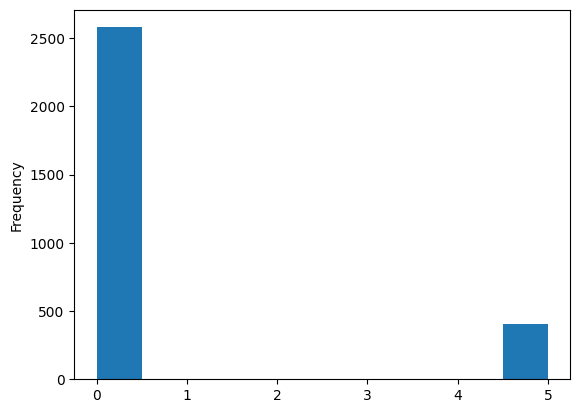

In [9]:
df_hi[feature_cols].isna().sum(1).plot(kind='hist');

In [10]:
df_hi_clean = df_hi.drop(df_hi[df_hi[feature_cols].isna().sum(1)==5].index)
print(df_hi_clean[feature_cols].isna().any().any())
df_hi_clean['created_account'].value_counts()

False


0    2367
1     213
Name: created_account, dtype: int64

In [11]:
df_hi_clean['created_account'].value_counts(normalize=True)

0    0.917442
1    0.082558
Name: created_account, dtype: float64

## 3. Pre-processing <a id='3'><a>  

## Train-test split
This has to be done before fitting any predictors to avoid data-leakage

In [12]:
X = df_hi_clean[feature_cols[:-1]]
y = df_hi_clean[feature_cols[-1]]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [13]:
y_train.value_counts(normalize=True)

0    0.917829
1    0.082171
Name: created_account, dtype: float64

<div class="alert alert-block alert-warning">
<b>Assumption:</b> 
The target classes are highly unbalanced; 92% did not take out a home insurance, whilst only 8% took it.<b>
</div>

### Imputation
Impute the missing values

# TODO: 
https://stackoverflow.com/questions/25239958/impute-categorical-missing-values-in-scikit-learn

In [14]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

In [15]:
try:
    imp = IterativeImputer(max_iter=10, random_state=0)
    imp.fit(X_train)
except:
    print('Error')

Error


In [16]:
try:
    imputer = KNNImputer(n_neighbors=2, weights="uniform")
    imputer.fit_transform(X_train)
except:
    print('Error')

Error


In [17]:
scaler = StandardScaler()
oh_encoder = OneHotEncoder(drop='first', sparse=False)

In [18]:
# Create a transformer pipeline
# The features will be transformed and output in the order of the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', oh_encoder, cat_cols),
        ('num', scaler, num_cols)
    ]
)

In [19]:
# preprocessor.fit(X_train)

In [20]:
# get the feature names back
# preprocessor.transformers_[0][1].get_feature_names()

In [21]:
ml_pipe = Pipeline(
        steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())]
    )

In [22]:
ml_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['relationship', 'sex',
                                                   'religion']),
                                                 ('num', StandardScaler(),
                                                  ['age', 'education_num',
                                                   'occupation_level',
                                                   'time_with_employer',
                                                   'hours_per_week'])])),
                ('classifier', LogisticRegression())])

In [23]:
pred_train = ml_pipe.predict(X_train)

In [24]:
train_accuracy = accuracy_score(y_train, pred_train)
train_accuracy

0.9198966408268734

In [25]:
f1_score(y_train, pred_train)

0.2583732057416268

## 3. Model Training  <a id='3'><a>  

In [55]:
models = [SVC(), DecisionTreeClassifier(random_state=42), RandomForestClassifier(random_state=42), GaussianNB(), LogisticRegression()]

In [59]:
trained_models = []

for model in models:
    
    ml_pipe = Pipeline(
        steps=[("preprocessor", preprocessor), ("classifier", model)]
    )
    
    ml_pipe.fit(X_train, y_train)
    
    pred_train = ml_pipe.predict(X_train)
    pred_test = ml_pipe.predict(X_test)
    
    # Evaluate Accuracy
    train_accuracy = accuracy_score(y_train, pred_train)
    test_accuracy = accuracy_score(y_test, pred_test)
    
    # Evaluate F1 score
    train_f1 = f1_score(y_train, pred_train)
    test_f1 = f1_score(y_test, pred_test)
    
    # Output
    model_name = model.__repr__().split(':')[0]
    print(f'{model_name}:\t TRA: {train_accuracy:.2%},\t TSA: {test_accuracy:.2%}\t TRF1: {train_f1:.2%},\t TSF1: {test_f1:.2%}')
#     print(f'{model_name}:\t TRA: {train_accuracy:.2%},\t TRF1: {train_f1:.2%}')
#     model_evals.append([model_name, train_accuracy, test_accuracy, train_f1, test_f1])
    trained_models.append(ml_pipe)

SVC():	 TRA: 91.78%,	 TSA: 91.63%	 TRF1: 0.00%,	 TSF1: 0.00%
DecisionTreeClassifier(random_state=42):	 TRA: 100.00%,	 TSA: 87.75%	 TRF1: 100.00%,	 TSF1: 27.52%
RandomForestClassifier(random_state=42):	 TRA: 100.00%,	 TSA: 92.25%	 TRF1: 100.00%,	 TSF1: 30.56%
GaussianNB():	 TRA: 34.94%,	 TSA: 40.16%	 TRF1: 19.96%,	 TSF1: 21.54%
LogisticRegression():	 TRA: 91.99%,	 TSA: 91.78%	 TRF1: 25.84%,	 TSF1: 25.35%


### 4.1 Hyper parameter tuning

In [75]:
# best_model.get_params()

In [70]:
best_model = trained_models[2]
# best_model

param_grid = [
    {'classifier__criterion': ["gini", "entropy", "log_loss"]}
 ]

clf = GridSearchCV(best_model, param_grid=param_grid, scoring='f1')
clf.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse=False),
                                                                         ['relationship',
                                                                          'sex',
                                                                          'religion']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'education_num',
                                                                          'occupation_level',
                                                                          'time_with_employer',
                                                                          'hours_per_week'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid=[{'classifier__criterion': ['gini', 'entropy',
                                                    'log_loss']}],
             scoring='f1')

In [76]:
pred_test = clf.best_estimator_.predict(X_test)
test_f1 = f1_score(y_test, pred_test)
test_f1

0.3055555555555555

In [77]:
confusion_matrix(y_test, pred_test)

array([[584,   7],
       [ 43,  11]])

## 5. Model Evaluation <a id='5'><a>  

In [41]:
forest = trained_models[2]

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

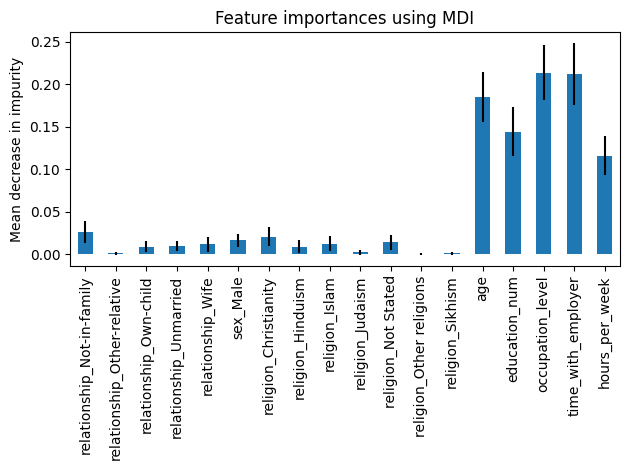

In [42]:
feature_names = preprocessor.transformers_[0][1].get_feature_names_out().tolist() + num_cols

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
print('f1: ', f1_score(y_train.map({'No':0, 'Yes':1}), y_train_pred))
print('recall: ', recall_score(y_train.map({'No':0, 'Yes':1}), y_train_pred))
print('recall: ', recall_score(y_train.map({'No':0, 'Yes':1}), y_train_pred))

print(confusion_matrix(y_train.map({'No':0, 'Yes':1}), y_train_pred, labels=[0, 1]))
print(confusion_matrix(y_train, y_train))

In [ ]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train.map({'No':0, 'Yes':1}))

y_train_pred = rfc.predict(X_train)

print('f1: ', f1_score(y_train.map({'No':0, 'Yes':1}), y_train_pred))
print('recall: ', recall_score(y_train.map({'No':0, 'Yes':1}), y_train_pred))
print('recall: ', recall_score(y_train.map({'No':0, 'Yes':1}), y_train_pred))

print(confusion_matrix(y_train.map({'No':0, 'Yes':1}), y_train_pred, labels=[0, 1]))
print(confusion_matrix(y_train, y_train))

In [ ]:
rfc.predict_proba(X_train)

In [ ]:
nb = GaussianNB()
nb.fit(X_train, y_train.map({'No':0, 'Yes':1}))

y_train_pred = nb.predict(X_train)

print('f1: ', f1_score(y_train.map({'No':0, 'Yes':1}), y_train_pred))
print('recall: ', recall_score(y_train.map({'No':0, 'Yes':1}), y_train_pred))
print('precision: ', precision_score(y_train.map({'No':0, 'Yes':1}), y_train_pred))

print(confusion_matrix(y_train.map({'No':0, 'Yes':1}), y_train_pred, labels=[0, 1]))
print(confusion_matrix(y_train, y_train))